# Tohoku tsunami inversion

Try solving the shallow water equations *without* using a mixed space.
Apply Explicit Euler to each component and solve iteratively.

In [1]:
%matplotlib inline

In [2]:
from thetis import *
from firedrake_adjoint import *

In [3]:
import matplotlib.pyplot as plt

In [4]:
from adapt_utils.case_studies.tohoku.options.options import TohokuInversionOptions
from adapt_utils.misc import gaussian, ellipse

In [5]:
def plot_field(field, figure=None, axes=None, height=5, **kwargs):
    CG1 = field.ufl_element().degree() == 1 and field.ufl_element().family() == 'Lagrange'
    fs_constructor = FunctionSpace if len(field.function_space().shape) == 0 else VectorFunctionSpace
    out = field if CG1 else interpolate(field, fs_constructor(field.function_space().mesh(), "CG", 1))
    
    if figure is None and axes is None:
        figure, axes = plt.subplots(figsize=(height*1.2, height))
    if axes is None:
        axes = plt.gca()
    figure.colorbar(tricontourf(out, levels=50, axes=axes, cmap='coolwarm', **kwargs), ax=axes);
    axes.axis(False);
    axes.set_title(field.dat.name);
    return axes

### Forward model

In [6]:
level = 0
op = TohokuInversionOptions(level=level)
gauges = list(op.gauges.keys())
for gauge in gauges:
    if gauge[:2] not in ('P0','80'):
        op.gauges.pop(gauge)
gauges = list(op.gauges.keys())
print(gauges)
op.end_time = 60*30
op.dt = 2.0

['801', '802', '803', '804', '806', '807', 'P02', 'P06']


In [7]:
mesh = op.default_mesh
P2 = VectorFunctionSpace(mesh, "CG", 2)
P1 = FunctionSpace(mesh, "CG", 1)
P0 = FunctionSpace(mesh, "DG", 0)

In [8]:
b = Function(P1).assign(op.set_bathymetry(P1))
g = Constant(op.g)
f = Function(P1).assign(op.set_coriolis(P1))

In [9]:
boundary_conditions = {100: ['freeslip', 'dirichlet'], 200: ['freeslip'], 300: ['freeslip']}

In [10]:
dtc = Constant(op.dt)
n = FacetNormal(mesh)

u = Function(P2)
eta = Function(P1)

u_trial = TrialFunction(P2)
eta_trial = TrialFunction(P1)
z = TestFunction(P2)
zeta = TestFunction(P1)

u_ = Function(P2)
eta_ = Function(P1)

lhs_u = inner(z, u_trial)*dx
rhs_u = inner(z, u_)*dx
rhs_u += -dtc*g*inner(z, grad(eta_))*dx
rhs_u += -dtc*f*inner(z, as_vector((-u_[1], u_[0])))*dx

lhs_eta = inner(zeta, eta_trial)*dx
rhs_eta = inner(zeta, eta_)*dx
rhs_eta += dtc*inner(grad(zeta), b*u_)*dx

bcs = [
    DirichletBC(P1, 0, tag)
    for tag in boundary_conditions
    if "dirichlet" in boundary_conditions[tag]
]

params = {
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "pc_type": "sor",
}
u_prob = LinearVariationalProblem(lhs_u, rhs_u, u, bcs=[])
eta_prob = LinearVariationalProblem(lhs_eta, rhs_eta, eta, bcs=bcs)
u_solver = LinearVariationalSolver(u_prob, solver_parameters=params)
eta_solver = LinearVariationalSolver(eta_prob, solver_parameters=params)

# Source model

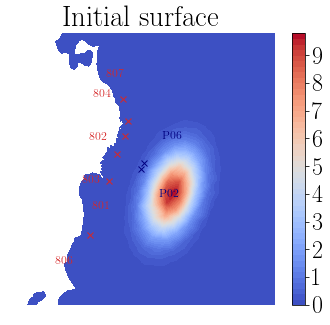

In [11]:
eta0 = Function(P1)
loc = (0.7e+06, 4.2e+06)
radii = (48e+03, 96e+03)
angle = pi/12
eta0.interpolate(10*gaussian([loc + radii], mesh, rotation=angle))

eta0.dat.name = "Initial surface"
axes = plot_field(eta0);
xg, yg = op.gauges["P02"]["coords"]
axes.set_xlim([xg - 0.3e+06, xg + 0.3e+06]);
axes.set_ylim([yg - 0.35e+06, yg + 0.35e+06]);
op.annotate_plot(axes)

## Forward solve

Now run the forward model, time integrating the QoI as time progresses.

In [12]:
def solve_forward(init):
    u_.assign(0.0)
    eta_.assign(init)
    t = 0.0
    J = 0
    iteration = 0
    wq = Constant(0.5)
    eta_obs = Constant(0.0)
    for gauge in gauges:
        op.gauges[gauge]['init'] = None
        if t < op.gauges[gauge]['arrival_time']:
                continue
        op.gauges[gauge]['init'] = eta_.at(op.gauges[gauge]['coords'])
        eta_obs.assign(op.gauges[gauge]['init'])
        J = J + assemble(wq*op.gauges[gauge]['indicator']*(eta - eta_obs)**2*dx)
    while t < op.end_time:
        if iteration % 30 == 0:
            print("t = {:2.0f} mins".format(t/60))

        # Solve forward equation at current timestep
        u_solver.solve()
        eta_solver.solve()
        u_.assign(u)
        eta_.assign(eta)
        t += op.dt
        iteration += 1

        # Time integrate QoI
        for gauge in op.gauges:
            if t < op.gauges[gauge]['arrival_time']:
                continue
            elif np.isclose(t, op.gauges[gauge]['arrival_time']):
                wq.assign(0.5*0.5*op.dt)
            elif np.isclose(t, op.gauges[gauge]['departure_time']):
                wq.assign(0.5*0.5*op.dt)
            elif t > op.gauges[gauge]['departure_time']:
                continue
            else:
                wq.assign(0.5*1.0*op.dt)
                
            # Interpolate observations
            if op.gauges[gauge]['init'] is None:
                op.gauges[gauge]['init'] = eta.at(op.gauges[gauge]['coords'])
            eta_obs.assign(float(op.gauges[gauge]['interpolator'](t)) + op.gauges[gauge]['init'])

            # Continuous form of error
            J = J + assemble(wq*op.gauges[gauge]['indicator']*(eta - eta_obs)**2*dx)

    assert np.allclose(t, op.end_time), "mismatching end time ({:.2f} vs {:.2f})".format(t, op.end_time)
    return J

Define gauge indicators

In [13]:
radius = 20.0e+03*pow(0.5, level)  # The finer the mesh, the more precise the indicator region
for gauge in gauges:
    loc = op.gauges[gauge]["coords"]
    op.gauges[gauge]['indicator'] = interpolate(ellipse([loc + (radius,)], mesh), P0)
    area = assemble(op.gauges[gauge]['indicator']*dx)
    op.gauges[gauge]['indicator'].assign(op.gauges[gauge]['indicator']/area)
    op.sample_timeseries(gauge, sample=op.gauges[gauge]['sample'], detide=True)

In [14]:
J = solve_forward(eta0)
print("Quantity of interest = {:.4e}".format(J))

t = 0.00
t = 60.00
t = 120.00
t = 180.00
t = 240.00
t = 300.00
t = 360.00
t = 420.00
t = 480.00
t = 540.00
t = 600.00
t = 660.00
t = 720.00
t = 780.00
t = 840.00
t = 900.00
t = 960.00
t = 1020.00
t = 1080.00
t = 1140.00
t = 1200.00
t = 1260.00
t = 1320.00
t = 1380.00
t = 1440.00
t = 1500.00
t = 1560.00
t = 1620.00
t = 1680.00
t = 1740.00
Quantity of interest = 2.1358e+04


<AxesSubplot:title={'center':'Free surface'}>

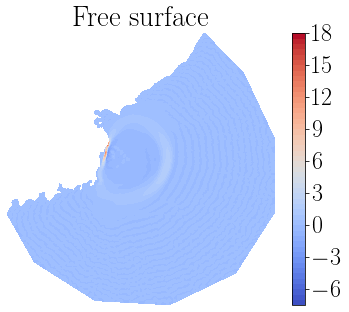

In [15]:
eta.dat.name = 'Free surface'
plot_field(eta)

## Discrete adjoint

Note that we only Taylor test the elevation and effectively zero out the perturbation away from the source.

In [17]:
c = Control(eta0)

In [18]:
stop_annotating();

In [19]:
Jhat = ReducedFunctional(J, c)

In [20]:
np.random.seed(0)
m0 = Function(P1).assign(eta0)
dm0 = Function(P1)
dm0.dat.data[:] = np.random.rand(*dm0.dat.data.shape)*m0.dat.data
m0 += dm0
minconv = taylor_test(Jhat, m0, dm0)
assert minconv > 1.90, minconv

Running Taylor test
epsilon 1.0000e-02  residual 6.4904e-01
epsilon 5.0000e-03  residual 1.6219e-01
epsilon 2.5000e-03  residual 4.0516e-02
epsilon 1.2500e-03  residual 1.0113e-02
Computed residuals: [0.649036058665672, 0.1621904613006393, 0.040516173899234786, 0.010112709481838067]
Computed convergence rates: [2.000609657956896, 2.0011191283301493, 2.0023283532628797]
